In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output, display
from ipywidgets import IntSlider, Output
plt.rcParams['animation.html'] = 'html5'

import numpy as np
import scipy as sp
import scipy.integrate
np.set_printoptions(linewidth=120)

import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from spectral import *
from elasticity import *

In [2]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    PK = rod.pk1(u)
    
    bval = (0, 0), (0, 0), (0, 0)
    F = PK.div(bval, coord='cylindrical')
    F -= damp(t)*v
    F = F.match_domains()  
    dv_dt = F/rod.rho
    
    return compress(du_dt, dv_dt)

def simulation(u0, v0, T, x, c):
    U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
    V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
    E = np.zeros(len(T))

    r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
    r.set_initial_value(compress(u0, v0), t=t0)

    out = Output()
    display(out)
    for k, t in enumerate(Progress(T)):
        if t > r.t:
            r.integrate(t)
        U[k], V[k] = decompress(r.y)
        #E[k] = rod.energy(U[k], V[k])
        out.clear_output(wait=True)
        with out:
            plt.figure(figsize=(6,3))
            plt.plot(x, U[k, 0].diff(0)(x + c*T[k], 0, 0)/np.abs(A0))
            plt.show()
            print("time:     %.2f ms" % (T[k]/1000.0))
            dist = c*T[k]
            print("distance: %.2f m" % (dist/1000.0))
    
    return U, V, E

In [3]:
def animate(k, u, c, T):
    line.set_data(x, u[k, :](x + c*T[k]))
    line2.set_data(x, damp(T[k])(x + c*T[k], 0, 0) - 0.75)
    time_template = 'time = %.1f'
    time_text.set_text(time_template % T[k])
    return line, time_text

def init(U, T, x):
    u = U[:, 0](None, 0, 0).diff()
    A0 = np.max(np.abs(u[0](x)))
    A0 *= np.sign(np.max(u[0](x)) - A0*(1.0 - 1e-10))
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(-0.8, 1.8)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$U_x(x, 0, 0)$')
    plt.close()
    return u/A0

# Smooth initial wave 

In [ ]:
direct = 'simulation_samples/FullEqn_table_top/'

In [4]:
#%%writefile simulation_samples/FullEqn_table_top2_mat1_A-0.01/data.py

# rod parameters
moduli = get_constants('landau', 'pmma')
moduli = np.asarray(moduli)
moduli[3:6] = moduli[3:6]*4.0
rod = CircularRod(600, 3, 'landau', moduli)

# mesh parameters
mesh_x = Multidomain(Legendre(20), np.linspace(0, rod.L, 21), periodic=True)
mesh_r = Legendre(5, (rod.R, 0), 'Radau')
mesh_phi = Constant()
mesh = mesh_x*mesh_r*mesh_phi
x_field, r_field, phi_field = TensorField(mesh, np.meshgrid(*mesh.grid(), indexing='ij'))

In [48]:
#%run -i 'simulation_samples/FullEqn_table_top2/data.py'

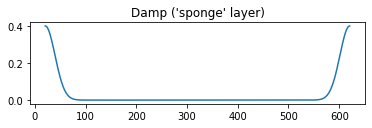

In [5]:
def damp(t):
    data = 0.4*np.cos(np.pi*(x_field.func - rod.c*t)/rod.L)**100
    return TensorField(mesh, data)

t = 10
x = x_field(None,0,0).func + rod.c*t
plt.figure(figsize=(6,1.5))
plt.plot(x, damp(t)(x,0,0))
plt.title("Damp ('sponge' layer)")
plt.show()

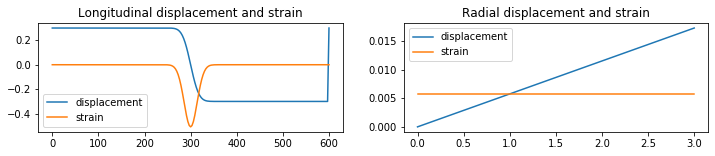

In [6]:
# Gaussian curve
width = 20
t0 = 0
t_max = 100.0
dt = 10.0
A0 = 0.015

T = np.arange(t0, t_max + dt/2, dt)
u_data = np.zeros((3,) + mesh.shape)
u_data[0] += -A0*width*sp.special.erf((x_field.func - rod.L/2)/width)
u0 = TensorField(mesh, u_data)
u0[1] -= rod.nu*r_field*u0[0].diff(0)
v0 = -rod.c*u0.diff()

# plot initial value
x = np.linspace(0, rod.L, 201)
r = np.linspace(0, rod.R, 101)
fig, ax = plt.subplots(1, 2, figsize=(12,2))
ax[0].plot(x, u0[0](x, 0, 0), x, 30*u0[0].diff(0)(x, 0, 0))
ax[0].set_title('Longitudinal displacement and strain')
ax[0].legend(['displacement', 'strain'], loc=3)
ax[1].plot(r, u0[1](rod.L/2, r, 0), r, u0[1].diff(1)(rod.L/2, r, 0))
ax[1].set_title('Radial displacement and strain')
ax[1].legend(['displacement', 'strain'], loc=2)
plt.show()

In [7]:
%%time
U, V, E = simulation(u0, v0, T, x, rod.c)

Output()

HTML(value='')

CPU times: user 3min 40s, sys: 7.16 s, total: 3min 47s
Wall time: 1min 54s


In [21]:
np.save(direct + 'mesh_grid.npy', mesh.grid())
np.save(direct + 'displacement.npy', U.func)
np.save(direct + 'time.npy', T)
#np.save(direct + 'energy.npy', E)

In [62]:
fig, ax = plt.subplots(figsize=(8,3))
line, = ax.plot([], [])
line2, = ax.plot([], [])
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)

u = init(U, T, x)
animation.FuncAnimation(fig, animate, frames=len(T[:10]), 
                        interval=1000, blit=True, fargs=(u, rod.c, T[:10]))

# Soliton as initial value

In [8]:
%%writefile simulation_samples/FullEqn_table_top_mat2_A-0.2/data.py

# rod parameters
moduli = get_constants('landau', 'mat2')
moduli = np.asarray(moduli)
rod = CircularRod(600, 3, 'landau', moduli)

# mesh parameters
mesh_x = Multidomain(Legendre(30), np.linspace(0, rod.L, 31), periodic=True)
mesh_r = Legendre(5, (rod.R, 0), 'Radau')
mesh_phi = Constant()
mesh = mesh_x*mesh_r*mesh_phi
x_field, r_field, phi_field = TensorField(mesh, np.meshgrid(*mesh.grid(), indexing='ij'))

Overwriting simulation_samples/FullEqn_table_top_mat2_A-0.2/data.py


In [9]:
%run -i 'simulation_samples/FullEqn_table_top_mat2_A-0.2/data.py'

<Figure size 432x288 with 0 Axes>

In [10]:
def f(U0):
    nu = rod.nu
    return nu*(1 - 2*nu)*(3 - 2*nu**2)*U0.diff(0).diff(0).diff(0)/8/(1 - nu)

def g(U0):
    return -rod.beta2*U0.diff(0)**2/4/rod.young

def U2(U0):
    return (rod.young - rod.lam - 2*rod.mu 
            + 2*rod.nu*(rod.lam + rod.mu))*U0.diff(0).diff(0)/4/rod.mu

def V3(U0, U2):
    return (-rod.nu*(rod.young - rod.mu)*U0.diff(0).diff(0).diff(0) 
            - 2*(rod.lam + rod.mu)*U2.diff(0))/8/(rod.lam + 2*rod.mu)

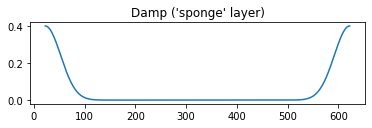

In [11]:
def indef_integral(u, x):
    u_int = np.zeros_like(u.func)
    for i in range(1, u_int.shape[0]):
        x0 = x_field.func[i - 1, 0, 0]
        x1 = x_field.func[i, 0, 0]
        x = np.linspace(x0, x1, num=100)
        u_int[i, 0, 0] = u_int[i - 1, 0, 0] + np.trapz(u(x, 0, 0), dx=(x1 - x0)/100)
        for j in range(1, u_int.shape[1]):
            u_int[i, j, 0] = u_int[i, 0, 0]
    return u_int

def damp(t):
    data = 0.4*np.cos(np.pi*(x_field.func - rod.c*t)/rod.L)**40
    return TensorField(mesh, data)

t = 10
x = x_field(None,0,0).func + rod.c*t
plt.figure(figsize=(6,1.5))
plt.plot(x, damp(t)(x,0,0))
plt.title("Damp ('sponge' layer)")
plt.show()

In [12]:
t0 = 0
t_max = 1000.0
dt = 50.0
A0 = -0.2

T = np.arange(t0, t_max + dt/2, dt)

In [13]:
xi = x_field - rod.L/2
v = rod.sol_gardner_params(A0)[2]
u_data = np.zeros((3,) + mesh.shape)
u_data[0] += rod.sol_gardner_displ(A0, xi.func, 0)
u_data_strain = rod.sol_gardner_strain(A0, xi.func, 0)
u0_strain = TensorField(mesh, u_data_strain)

u1 = rod.R**2*rod.a1*u0_strain.diff(0).diff(0)
u2 = rod.a2*(xi*v/rod.c*u0_strain.diff(0))
u3 = rod.a3*TensorField(mesh, u0_strain.diff(0).func*
                        rod.sol_gardner_displ(A0, xi.func, 0))
u0 = TensorField(mesh, u_data)
u0[0] -= TensorField(mesh, indef_integral(u1 + u2 + u3, xi))
#u0_plain = TensorField(mesh, u_data)
u0[1] -= r_field*rod.nu*u0[0].diff(0)
#u0[0] += r_field**2*U2(u0_plain[0])
#u0[1] += (r_field*(g(u0_plain[0]) + rod.R**2*f(u0_plain[0]))
#          + r_field**3*V3(u0_plain[0], U2(u0_plain[0])))
v0 = -(rod.c + v)*u0.diff(0)

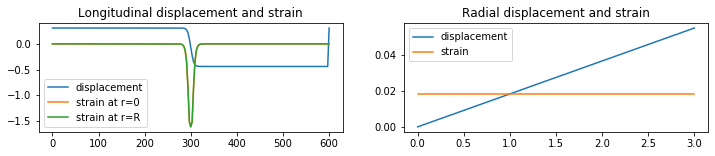

In [14]:
# plot initial value
x = np.linspace(0, rod.L, 201)
r = np.linspace(0, rod.R, 101)
fig, ax = plt.subplots(1, 2, figsize=(12,2))
ax[0].plot(x, u0[0](x, 0, 0), x, 30*u0[0].diff(0)(x, 0, 0), x, 30*u0[0].diff(0)(x, 5, 0))
ax[0].set_title('Longitudinal displacement and strain')
ax[0].legend(['displacement', 'strain at r=0', 'strain at r=R'], loc=3)
ax[1].plot(r, u0[1](rod.L/2, r, 0), r, u0[1].diff(1)(rod.L/2, r, 0))
ax[1].set_title('Radial displacement and strain')
ax[1].legend(['displacement', 'strain'], loc=2)
plt.show()

In [15]:
%%time
U, V, E = simulation(u0, v0, T, x, rod.c)

Output()

HTML(value='')

CPU times: user 1h 27min 58s, sys: 4min 43s, total: 1h 32min 42s
Wall time: 23min 11s


In [17]:
%%time
U2, V2, E2 = simulation(U[-1], V[-1], T, x, rod.c)

Output()

HTML(value='')

CPU times: user 1h 19min 30s, sys: 3min 46s, total: 1h 23min 17s
Wall time: 20min 49s


In [29]:
U_full = TensorField(mesh, np.append(U.func, U2.func[1:], axis=0))

In [39]:
T_full = [*T,] + [*(T[1:] + T[-1]),]
T_full = np.asarray(T_full)

In [41]:
U = U_full
T = T_full

In [42]:
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot([], [])
line2, = ax.plot([], [])
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)

u = init(U, T, x)
animation.FuncAnimation(fig, animate, frames=len(T), 
                        interval=100, blit=True, fargs=(u, rod.c, T))

In [43]:
direct = 'simulation_samples/FullEqn_table_top_mat2_A-0.2/'

In [44]:
np.save(direct + 'mesh_grid.npy', mesh.grid())
np.save(direct + 'displacement.npy', U.func)
np.save(direct + 'time.npy', T)
#np.save(directory + 'energy.npy', E)

# Analysis

In [71]:
x = np.linspace(0, rod.L, 1000)

def soliton(x, X, A, L, B=0):
    return A/(B + np.cosh((x - X)/L)**2)

def fit(k, thr=0.7, optimize=True):
    u = -U[k, 0](None, 0, 0).diff()(x + c*T[k])
    i = u.argmax()
    X = x[i]
    A = u[i]
    L = np.trapz((u > thr*A).astype(float), x)/2/np.arccosh(1/np.sqrt(thr))
    if optimize:
        mask = (x > X - 2*L)*(x < X + 2*L)
        X, A, L = sp.optimize.curve_fit(soliton, x[mask], u[mask], (X, A, L))[0]
    return X, A, L
    
Xs, As, Ls = np.transpose([fit(k) for k in Progress(len(T))])

HTML(value='')

NameError: name 'c' is not defined

In [ ]:
dv_num, X0 = np.polyfit(T[T > t_max/2], Xs[T > t_max/2], 1)
plt.plot(T, Xs)
plt.plot(T, X0 + dv_num*T)
plt.xlabel('$t$')
plt.ylabel('$X_s - ct$')
dv_num

In [159]:
beta1 = 3*young + 2*l*(1-2*nu)**3 + 4*m*(1+nu)**2*(1-2*nu) + 6*n*nu**2
v = c + dv_num
A_th = -3*rho*(v**2 - c**2)/beta1
L_th = v*nu*R*np.sqrt(2/(v**2 - c**2))
A_th

0.002336624964944028

0.0026014018622302075

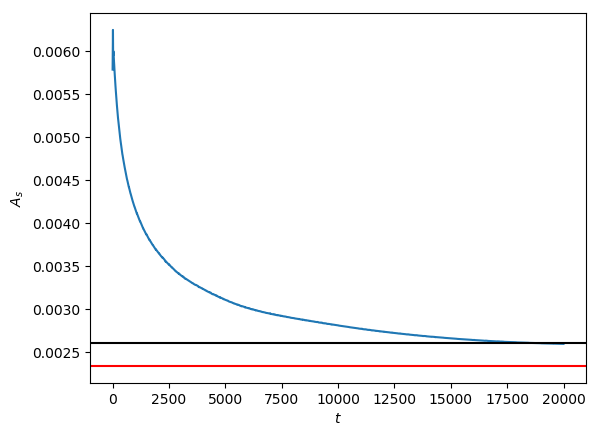

In [160]:
A_num = np.mean(As[T > 0.9*t_max])
plt.plot(T, As)
plt.axhline(A_num, c='k')
plt.axhline(A_th, c='r')
plt.xlabel('$t$')
plt.ylabel('$A_s$')
A_num

57.33444212626433

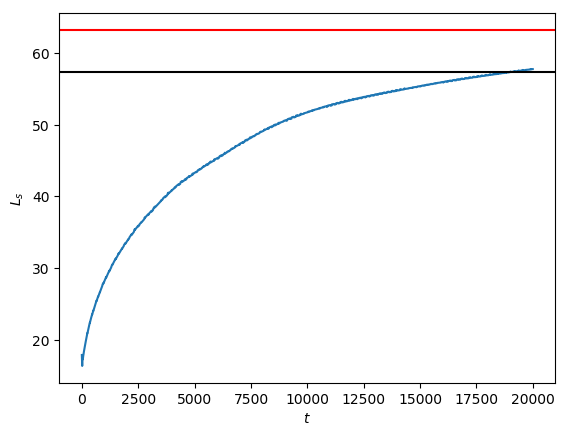

In [161]:
L_num = np.mean(Ls[T > 0.9*t_max])
plt.plot(T, Ls)
plt.axhline(L_num, c='k')
plt.axhline(L_th, c='r')
plt.xlabel('$t$')
plt.ylabel('$L_s$')
L_num

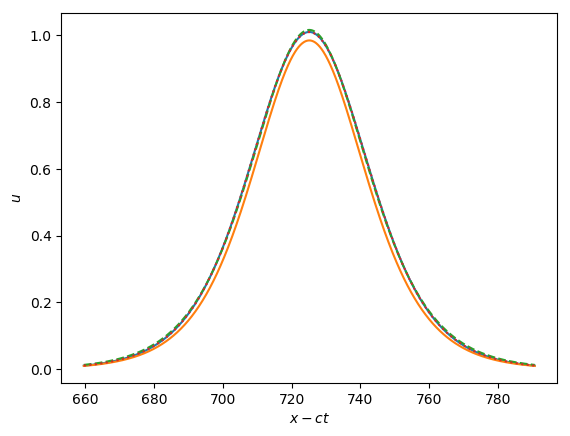

In [148]:
k = -1
x = np.linspace(X0 + (v - c)*T[k] - 3*L_th, X0 + (v - c)*T[k] + 3*L_th, 1000)
u = -U[k, 0](None, 0, 0).diff()/A0
plt.xlabel(r'$x - ct$')
plt.ylabel(r'$u$')
plt.plot(x, u(x + c*T[k]))
plt.plot(x, soliton(x, X0 + (v - c)*T[k], A_th, L_th)/A0)

XAL = sp.optimize.curve_fit(soliton, x, u(x + c*T[k]), (X0 + (v - c)*T[k], A_th, L_th))[0]
XALB = sp.optimize.curve_fit(soliton, x, u(x + c*T[k]), (X0 + (v - c)*T[k], A_th, L_th, 0))[0]
plt.plot(x, soliton(x, *XAL), '--')
plt.plot(x, soliton(x, *XALB), ':')

In [149]:
XAL

array([725.12616928,   1.01577553, -22.76212278])

In [150]:
XALB

array([ 7.25126147e+02,  1.20041430e+00, -2.15238387e+01,  1.89277203e-01])

In [151]:
fig, ax = plt.subplots(figsize=(8,6))
plt.xlim(0, L)
plt.ylim(-1, 2)
line, = ax.plot([], [])
line2, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.close()
p = Progress(len(T))
def animate(k):
    p.update()
    u = -U[k, 0](None, 0, 0).diff()/A0
    x = np.linspace(0, L, 1000)
    line.set_data(x, u(x + c*T[k]))
    line2.set_data(x, soliton(x, X0 + (v - c)*T[k], A_th, L_th)/A0)
    time_text.set_text(time_template % T[k])
    return line, line2, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=20, blit=True)

HTML(value='')